# I. Overview of Counting Bloom Filters (CBFs)
## 1. Standard Bloom Filters (BFs)
### 1.1. What is it?
A bloom filter is a data structure that is used to test whether an element x is in a set of elements S or not, by returning either True or False. If the result is False, it means that x is definitely not in S. If the result is True, it means x is in S. However, false positives may arise, because if we get True, practically, it only means that x is highly likely in S. Even though the probability of false positives is usually low, it is still something we should keep in mind when using bloom filters. ("Bloom filter," n.d.)
### 1.2. How is it done?
Imagine a set of identical boxes lined up altogether and our job is to put different fruits (3 of each type) in those boxes. Initially, all boxes are empty, so we mark them as 0. There must be a mechanism of which box to put in certain fruits. For example, if we have 3 apples, put each of them in box 1, box 3, box 5. 3 oranges, each in box 2, box 4, box 10. 3 strawberries, box 1, box 4, box 13. Essentially, each type of fruits is matched with 3 boxes. If a box is occupied by at least one fruit, it is marked as 1. 
Similarly, a hash table is the set of slots where we can put different elements in. The mechanism to put each element (key) in its proper slot in the hash table is called hash functions. Bloom filters are one type of such hash tables, where we have more than 1 hash functions to determine the slots of each key (just like for each type of fruits, we put it in 3 boxes). Initially, all slots are set to 0. If there is at least one key in a slot, the slot is changed to 1. So the state of each slot in the standard bloom filters indicates whether there is any key in it or not.

So how is the search done? For example, we have a hash table with 15 slots, different numbers (keys) x_1, x_2,... and 2 different hash functions: h_1, h_2. h_1(x) = x % 15 and h_2(x) = (x + 7) % 15. If x_1 = 3, it is virtually put in slot 3 and slot 10. Hence, slot 3 and slot 10 change their states to 1. If x_2 = 5, slot 5 and slot 12 change their state to 1. Now if we want to check if x_i = 7 is in the table or not, we can check slot 7 and slot 14 and if either of them is 0, we can conclude that 7 is not in the table. Apparently, it is not. If we want to search for x_j = 20 in the table, we have to check slots 5 and 12. Because both of them are 1, we can conclude that 20 is in the table, even though it is not! This is a false positive.
## 2. Counting Bloom Filters
### 2.1. What is it?
CBFs are an extension of standard bloom filters. Instead of having only 0 and 1 (one-bit) as states of the slots, we can have other numbers (n-bit) as the states. These states are actually the number of keys in the slots. For example, if we put one key into slot 1 which is empty, its state is changed to 1. If we put another key into slot 1, its state is 2, etc. ("Bloom filter," n.d.)
### 2.2. Types of operations
- Search: Apparently, both standard BFs and CBFs allow for the query (search) of an element as explained above. The advantage of bloom filters over other hash tables such as chained hash tables or linear probing hash tables is that even though its size is fixed, it never fills up, because we do not actually put keys into slots, we just demonstrate whether a key is virtually in a slot or not by changing the state of that slot. Even though we are faced with false positives (whose probability could be very low if we choose the right parameters), we will not end up with large search complexity that costs a lot of time like in other types of hash tables. ("Bloom filter," n.d.)
- Insertion: Both standard BFs and CBFs allow insertion. It is actually "virtual" insertion, because the elements do not appear in the table, but indicated through the states of the slots in the table. ("Bloom filter," n.d.)
- Deletion: Standard BFs do not support deletion. If we want to delete the presence of one element, we just need to set one of its slots to 0, which will result in the deletion of another element that shares the same slot. Hence, we will face false negatives, when we conclude that one element is not in the table, while it is (if it is not supposed to be deleted!). However, CBFs do allow deletion. The states of the slots represent the number of keys in them, so when we insert a key, we increment the state by 1, when we delete a key, we decrement the state by 1. Therefore, we can only conclude that an element is not in the table if one of its slots is 0, which truly indicates that there is no key in that slot whatsoever. False negatives are not a problem anymore. ("Bloom filter," n.d.)

### 2.3. Applications
- To allow access to certain websites: I use several apps like Self-Control to prevent myself from several websites for a certain amount of time. During that time, if I open a website, the server will check whether the website is in the "black list" or not. If yes, I can't open the website. If no, I can open it. This can scale up to millions of websites for millions of Internet users. Hence, CBFs are the suitable data structure to use.
- Spelling check: The commonly used words are virtually stored in the hash table, and the filter will check to see if each word typed down is in the storage or not. If it is, it is correctly spelled, if it is not, it is misspelled.

# II. Implementing CBSs with 3 hash functions
## 1. Data and hyperparameters
- The data is a list of 36651 US cities.
- The bloom filter is an array (hash table) of length m = 1000 and we will virtually put n = 700 random cities from the city list into the array.
- The number of hash functions used is k = 3.

## 2. Hash functions
### Hash functions being used
- The three hash functions are Python built-in hash function, Murmurhash1 and SHA256. They are all known to be good cryptographic and non-cryptographic hash functions, that result in a smaller number of collisions than most other hash functions.
- Uniform distribution of hash values is one of the most important factors in assessing a hash function, besides how fast it is. Below, I examined how uniformly distributed the hash values of each hash function are. The first 1500 US cities are stored in 3 different hash tables all sized 1000. As we can see, the distributions are not perfectly uniform but they are not skewed to one side either. Therefore, these hash functions are decent to use.

In [134]:
import csv
import numpy as np
import murmurhash as mmh
import hashlib
import time
import math
import matplotlib.pyplot as plt
from sys import getsizeof

# import data file, extract the cities column
with open('uscities.csv', newline='') as csvfile:
    data = list(csv.reader(csvfile))
cities = (np.array(data))[1:,0]
cloned_cities = list(cities)
stored_cities = []
l = len(cities)

# set the hyperparameters
k = 3
n = 700
m = 1000
hash_table = np.zeros(m)

# the 3 hash functions, each returns the slot of each city in the hash table
def hash_1(x):
    return (hash(x) % m)
def hash_2(x):
    return mmh.hash(x) % m
def hash_3(x):
    y = hashlib.sha256(x.encode())
    return int(y.hexdigest(), 16) % m

# virtuall store cities in the hash table
def insert_city(hash_table, city):
    hash_table[hash_1(city)] += 1
    hash_table[hash_2(city)] += 1
    hash_table[hash_3(city)] += 1
    stored_cities.append(city)
    return stored_cities, hash_table

In [135]:
# Test how uniform the distribution of hash values of each hash function is

# Python built-in hash function
index_list_1 = []
for each in range(1500):
    # append all hash values to a list
    index_list_1.append(hash_1(str(cities[each])))
# Murmurhash 
index_list_2 = []
for each in range(1500):
    index_list_2.append(hash_2(str(cities[each])))
# SHA256
index_list_3 = []
for each in range(1500):
    index_list_3.append(hash_3(str(cities[each])))

Text(0, 0.5, 'Frequencies')

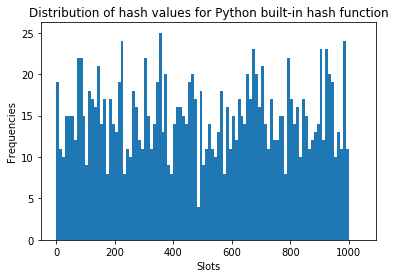

In [136]:
# histogram of the hash values
plt.hist(index_list_1, bins=[b for b in range(0,1050,10)])
plt.title("Distribution of hash values for Python built-in hash function")
plt.xlabel("Slots")
plt.ylabel("Frequencies")

Text(0, 0.5, 'Frequencies')

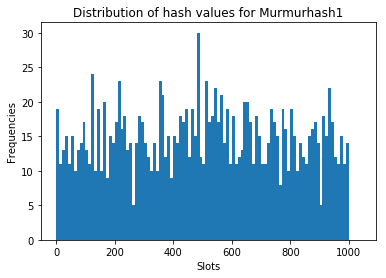

In [137]:
plt.hist(index_list_2, bins=[b for b in range(0,1050,10)])
plt.title("Distribution of hash values for Murmurhash1")
plt.xlabel("Slots")
plt.ylabel("Frequencies")

Text(0, 0.5, 'Frequencies')

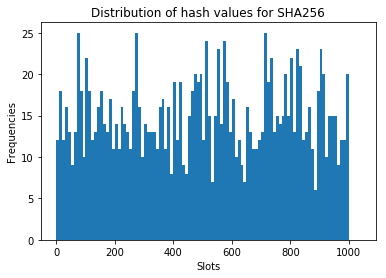

In [138]:
plt.hist(index_list_3, bins=[b for b in range(0,1050,10)])
plt.title("Distribution of hash values for SHA256")
plt.xlabel("Slots")
plt.ylabel("Frequencies")

# III. Memory size and access time

In [139]:
# The "star" of CBFs, to conclude whether an item is stored or not
def search_city(hash_table, lost_city, access_time):
    found = False
    start = time.time()
    # check whether the item is stored or not
    if hash_table[hash_1(lost_city)] != 0 and hash_table[hash_2(lost_city)] != 0 and hash_table[hash_3(lost_city)] != 0:
        found = True
    end = time.time()
    # real-life access time
    access_time += (end - start)
    return found, access_time

# Check the memory size of the hash table
def memory_size(hash_table):
    memory_size = 0
    for each in hash_table:
        # if the state of the slot is 0, it has 1 bit
        if int(each) == 0:
            memory_size += 1
        # otherwise, get the number of bits of the slot
        else:
            memory_size += int((math.log(int(each)) / math.log(2)) + 1)
    return memory_size

In [140]:
# number of items stored
N = []
# memory size
memory_list = []
real_memory_list = []
# access time
access_time_list = []
# false positive rate
fp_list_emp = []
fp_list_theo = []

for i in range(n):
    # number of cities in hash table (items stored)
    N.append(i+1)
    
    # get a random city that has not been stored
    city = str(np.random.choice(cloned_cities))
    cloned_cities.remove(np.str(city))
    
    # store the city, update the hash table
    stored_cities, hash_table = insert_city(hash_table, city)
    
    # search for cities
    fp_emp = 0
    access_time = 0
    # for 100 random cities
    for j in range(100):
        lost_city = str(np.random.choice(cities))
        # look for the city
        found, access_time = search_city(hash_table, lost_city, access_time)
        # check if it is a false positive and add to the number of false positive
        if (lost_city not in stored_cities) and found == True:
            fp_emp += 1
    
    # false positive rate for each number of items stored
    fp_list_emp.append(fp_emp / 100)
    # averaged search time for each number of items stored
    access_time_list.append(access_time / 100)
    
    
    # theoretical false positive rate for each number of items stored
    fp_theo = (1-math.exp(-k*(i+1)/m))**k
    fp_list_theo.append(fp_theo)
    
    # real memory size of the hash table
    real_memory = getsizeof(hash_table)
    real_memory_list.append(real_memory)
    
    # theoretical memory size of the hash table
    memory = memory_size(hash_table)
    memory_list.append(memory / 8)
    

## 1. Memory size as a function of number of items stored
### 1.1. Theoretical analysis
We just need to calculate the bits of the state of each slot in the hash table. For example, if the slot is 0 or 1, it has 1 bit. If the slot is 10, the binary representation of 10 is 1010, therefore it has 4 bits. For each number of items stored, we just need to sum up all the bits of all the slots, then divide it by 8 to get the bytes, since 8 bits equals 1 byte.

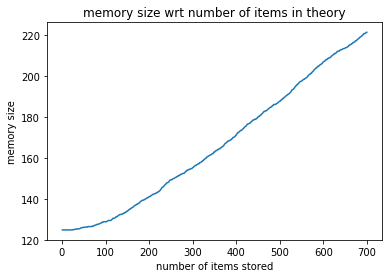

In [141]:
# Memory size wrt number of items stored in theory
plt.plot(N, memory_list)
plt.title("memory size wrt number of items in theory")
plt.xlabel("number of items stored")
plt.ylabel("memory size")
plt.show()

### 1.2. Empirical analysis
Because Python is a high-level programming language, it is very efficient in storing data. Therefore, when getting the memory space occupied by an array, it does not really care what is stored in the array. As long as the array size stays the same, the amount of memory it occupies is the same. However, the number of bytes returned (even though constant) is a lot bigger than the number of bytes measured analytically. This might be because it has to take into account a lot of other factors such as the way the array is contructed, the operations around the array, etc.

Text(0, 0.5, 'memory size')

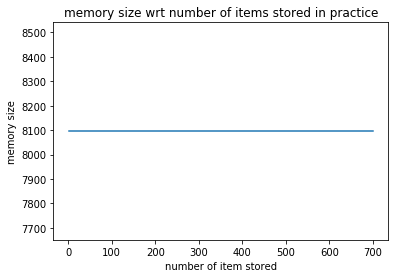

In [142]:
# Memory size wrt number of items stored in practice
plt.plot(N, real_memory_list)
plt.title("memory size wrt number of items stored in practice")
plt.xlabel("number of item stored")
plt.ylabel("memory size")

## 2. Memory size as a function of false positive rate
### 2.1. Theoretical analysis
Because the false positive rate increases as the number of items stored increases (proved in part IV), the theoretical memory that the hash table occupies increases as the false positive rate increases.

Text(0, 0.5, 'memory size')

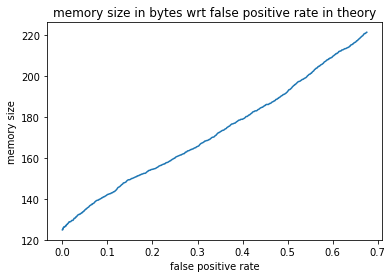

In [143]:
# memory size as a function of false positive rates in theory
plt.plot(fp_list_theo, memory_list)
plt.title("memory size in bytes wrt false positive rate in theory")
plt.xlabel("false positive rate")
plt.ylabel("memory size")

### 2.2. Empirical analysis
Same explanation as 1.2.

Text(0, 0.5, 'memory size')

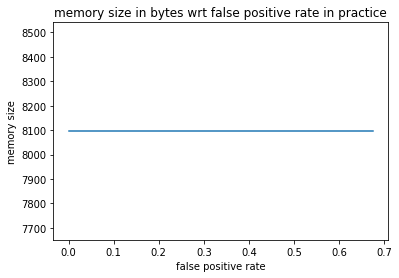

In [144]:
# Memory size wrt false positive rate in practice
plt.plot(fp_list_theo, real_memory_list)
plt.title("memory size in bytes wrt false positive rate in practice")
plt.xlabel("false positive rate")
plt.ylabel("memory size")

## 3. Access time as a function of false positive rate
### 3.1. Theoretical analysis
- The false positive rate is a function of the array length, number of items stored and number of hash function. However, it does not have any effect on the access time.The
- In order to check if an item is stored or not, we just need to check the states of its hash values. If all of them are bigger than 0, we have found the item, otherwise, the item is not in the array.
- The number of hash functions used is pre-determined (in this case, k = 3)
- Therefore, the time it takes does not depend on the length of the array or the number of items stored in the array. Hence, the complexity is constant time, O(c).

### 3.2. Experimental analysis
In the plot below, on a big scale, there is almost no difference in the access time for different false positive rates (approximately 0.0000075 vs. 0.000001 for longest and shortest time), which fits the theoretical conclusion. However, if we zoom in, we can notice an stable increase in the access time as false positive rate increases. This might be because as the false positive rate increases, it means we store more items, the computer has to remember more things, so it is slower in accessing queried items.

Text(0, 0.5, 'access time')

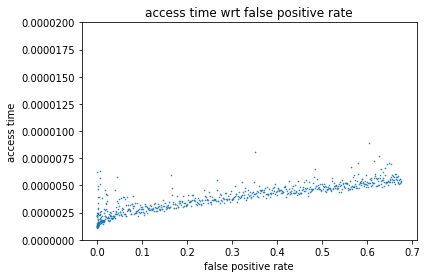

In [145]:
# access time with respect to false positive rate in practice
plt.scatter(fp_list_theo, access_time_list, s=0.3)
plt.ylim(0, 0.00002)
plt.title("access time wrt false positive rate")
plt.xlabel("false positive rate")
plt.ylabel("access time")

## 4. Access time as a function of number of items stored
### 4.1. Theoretical analysis
The complexity for access time is constant time, as proved above.
### 4.2. Experimental analysis
In the plot below, on a big scale, there is almost no difference in the access time for different numbers of stored items (approximately 0.0000075 vs. 0.000001 for longest and shortest time), which fits the theoretical conclusion. However, if we zoom in, we can notice an stable increase in the access time as the number of stored items increases. This might be because as we store more items, the computer has to remember more things, so it is slower in accessing queried items. 

Text(0.5, 1.0, 'access time wrt number of items')

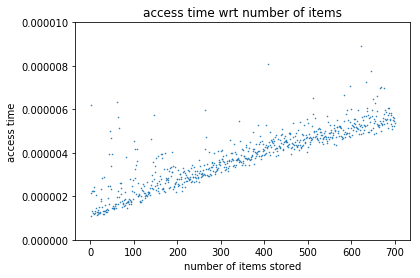

In [146]:
# access time with respect to number of items stored in practice
plt.scatter(N, access_time_list, s=0.3)
plt.ylim(0, 0.00001)
plt.xlabel("number of items stored")
plt.ylabel("access time")
plt.title("access time wrt number of items")

# IV. Empirical vs. theoretical false positive rate
## 1. Calculations
### 1.1. Theoretical false positive rate
Given k as the number of hash functions, m as the length of the array, n as the number of items stored, in theory, the false positive rate is:
$$ p=(1-e^r)^k $$, $$r=\frac{-kn}{m}$$
("Bloom filter," n.d.)
### 1.2. Empirical false positive rate
In the code above, we calculated the empirical false positive rate for each number of items stored, from 0 to 700. For each n, we store the stored cities in another list and search for 100 random cities in the original list. If a city is found in the hash table but not stored in the list of stored cities, this counts as a false positive. The false positive rate is the number of cities found in the hash table but not found in the list of stored cities out of 100 cities.

## 2. Comparison
As we can see, in the big picture, the trend in the empirical false positive rate is similar to the shape of the theoretical one. If we zoom in one small region, for example somewhere around 250, we can see quite great fluctuations. This might be accounted for by the randomization of the cities that need to be found. When we randomly pick a city, its hash values could be different from those of the stored cities, but could also be the same.

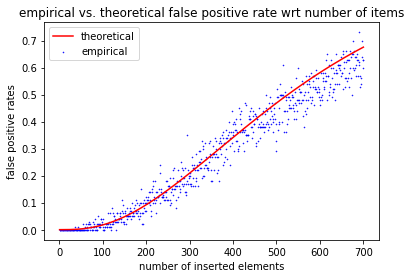

In [147]:
# empirical vs. theoretical false positive rate with respect to number of items stored
plt.plot(N, fp_list_theo, color="red", label="theoretical")
plt.scatter(N, fp_list_emp, color="blue", label="empirical",s=0.3)
plt.title("empirical vs. theoretical false positive rate wrt number of items")
plt.xlabel("number of inserted elements")
plt.ylabel("false positive rates")
plt.legend()

# V. Corner cases
### Possible corner cases
- In CBFs, what we are concerned about the most is the false positive rate. Therefore, if we have a very small array with a very large number of items to store, a lot of collisions could occur. In that case, even if an item is not stored, but its hash values indicate that it is there, we will get a very high false positive rate.
- Besides, even though analytically, the false positive rate does not depend on the types of hash functions, in practice, what hash functions to use does affect the false positive rate to some extent. For example, if a hash function returns a lot of collisions and very unequal distributions of hash values, the false positive rate could be very high.

# VI. References
N/A. “United States Cities Database.” Simplemaps, Apr. 2018, simplemaps.com/data/us-cities.

Wikipedia contributors. (2019, February 4). Bloom filter. In Wikipedia, The Free Encyclopedia. Retrieved 15:43, March 9, 2019, from https://en.wikipedia.org/wiki/Bloom_filter